# Финальный проект по курсам "Машинное обучение" от Яндекса и МФТИ

## Выполнил: Тодосиев Никита

## 1. Цели и задачи проекта, описание исходных и обработанных данных и признаков.

Цель проекта: автоматически предупреждать опасность взлома аккаунта пользователя.

Задача проекта: разработать алгоритм, который позволит идентифицировать пользователя по его пользовательской сессии. Сессия - это серия сайтов, на которых бывал пользователь.

Исходными признаками является:

 - номер пользователя;
 - время посещения страницы;
 - посещенная страница.
 
Каждый пользователь имеет свой выгруженный .csv-файл со своим списком посещенных сайтов, что необходимо обязательно объединить. 

Обработанные признаки:

 - разреженная матрица посещенных сайтов;
 - день недели начала сессии (категориальный признак);
 - время суток начала сессии (категориальный признак);
 - длина сессии (категориальный признак);
 - количество уникальных сайтов в сессии. (категориальный признак)
 
На обработанных признаках решается задача классификации (идентификации) пользователей.

## 2. Первичный анализ признаков

In [1]:
import pandas as pd
import pickle
from glob import glob
import os
import datetime
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, learning_curve
from scipy import stats
import itertools
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm_notebook as tqdm
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Список всех ссылок для удобной демонстрации файлов
path_user0031 = 'data/10users/user0031.csv'
path_150users = 'data/150users/'
path_sparse_10users = 'data/train_data_10users.csv'
path_features_10users = 'data/new_features_10users.pkl'
path_X_sparse_150users = 'data/X_sparse_150users_s{}_w{}.pkl'
path_y_sparse_150users = 'data/y_150users_s{}_w{}.pkl'
path_150users_dict = 'data/site_freq_150users.pkl'

Попробуем проанализировать ифнормацию по одному пользователю:

In [3]:
df = pd.read_csv(path_user0031)
df.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


In [4]:
df.site.describe()

count                    7600
unique                    962
top       webmail.laposte.net
freq                      399
Name: site, dtype: object

Есть информация о том, сколько сайтов он посетил, какой сайт был самым популярным для данного пользователя и количество уникальных сайтов, однако подобная информация не позволяет идентифицировать конкретного пользователя среди множества других.

## 3. Описание предобработки данных

Обработку посещенных сайтов пользователей будем проводить в несколько этапов:

 1. Кодирование сайтов. Для этого получим списки посещенных сайтов всех пользователей, отсортируем их и выставим им соответствующие числовые значения, а также количество посещений сайта для дополнительного анализа:

In [5]:
def prepare_site_dict(path_to_csv_files):
    files = glob(os.path.join(path_to_csv_files, '*.csv'))
    dataframes = []
    sites_global = []
    for file in files:
        dataframes.append(pd.read_csv(file))
    user_id = 1
    with tqdm(total=len(dataframes)) as pbar:
        pbar.set_description('processed "work with files"')
        for df in dataframes:
            sites_global.append(df.site.values)
            if user_id > 1:
                df_final = pd.concat([df_final, df])
            else:
                df_final = df
            user_id += 1
            pbar.update(1)

    sites_by_popularity = df_final.groupby('site').count().sort_values('timestamp', ascending=False).timestamp
    site_dict = {}
    for i in np.arange(sites_by_popularity.shape[0]):
        site_dict[sites_by_popularity.index[i]] = (i+1, sites_by_popularity.values[i])
        
    return site_dict

2. Создание сессий посещенных сайтов. Это позволит идентифицировать пользователя лишь по части сайтов, которые посещал пользователь. Также дополним алгоритм методом скользящего окна, который позволит получать еще больше сессий пользователя для лучшего обучения. Для того, чтобы не терять информацию о времени, добавим также признаки времени начала сессии (день недели, время суток)

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

#Функция получения датасета с признаками времени
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    # Откроем заранее полученный словарь сайтов для кодирования в числа
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)

    # Вспомогательная функция для работы со словарём
    def dict_id(site):        
        return site_dict[site][0]

    delta = session_length - window_size
    files = glob(os.path.join(path_to_csv_files, '*.csv'))
    sites_global = []
    timestamps = []
    rows_list = []
    fmt = '%Y-%m-%d %H:%M:%S'

    for file in files:
        df = pd.read_csv(file)
        # Последние символы обозначали номер пользователя
        user_id = int(file[-8:-4])
        i = 0
        while i < df.shape[0]:
            # Создание сессий из файла
            session = []
            start_timestamp = datetime.datetime.strptime(df.timestamp.values[i], fmt) # Время начала сессии
            start_hour = start_timestamp.hour # Час начала сессии
            day_of_week = start_timestamp.weekday() # День недели сессии
            for j in np.arange(session_length):
                if i >= df.shape[0]:
                    session.append(0)
                else:
                    session.append(dict_id(df.site.values[i]))
                    end_timestamp = df.timestamp.values[i]
                i += 1
            unique_sites = len(np.unique(session))
            if 0 in session:
                unique_sites -= 1
            session.append((datetime.datetime.strptime(end_timestamp, fmt) - start_timestamp).seconds)
            session.extend([unique_sites, start_hour, day_of_week, user_id])
            rows_list.append(session)
            
            # Отодвигаем назад на delta для реализации скользящего окна
            i -= delta
            if i >= df.shape[0]:
                break
    data = np.array(rows_list)
    final_df = pd.DataFrame(data, columns=feature_names)
    return final_df

In [7]:
train_set = prepare_train_set_with_fe(path_150users, path_150users_dict, feature_names)

In [8]:
train_set.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1293,321,57,5,8,4,6
1,2,23,1510,1293,321,321,113,73,49,49,1618,8,8,4,6
2,321,205,1,1,1,1,73,321,2,1,2010,5,8,4,6
3,1,1,7299,7299,5653,7299,7299,1,35,1,2006,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,10,5,9,4,6


In [9]:
X, y = train_set.iloc[:,:-1], train_set.iloc[:,-1]

Посещенные сайты имеют формат целочисленных значений, на чём обучать модель не стоит. Для разрешения этой проблемы приводим посещенные сайты в вид разреженных матриц, и присоединим остальные признаки к нему.

In [10]:
from scipy.sparse import hstack
def get_sparse_matrix_sites(X):
    indptr = [0]
    indices = []
    data = []
    for d in X:
        for term in d:
            if term == 0:
                continue
            indices.append(term-1)
            data.append(1)
        indptr.append(len(indices))

    X_sparse = csr_matrix((data, indices, indptr), dtype='int8')
    return X_sparse

def add_time_features(df, X_sparse):
    # Категоризация дней недели
    day_of_week = df['day_of_week']
    monday = (day_of_week == 0).astype('int')
    tuesday = (day_of_week == 1).astype('int')
    wednesday = (day_of_week == 2).astype('int')
    thursday = (day_of_week == 3).astype('int')
    friday = (day_of_week == 4).astype('int')
    saturday = (day_of_week == 5).astype('int')
    sunday = (day_of_week == 6).astype('int')
    
    # Категоризация времени суток
    hour = df['start_hour']
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 17)).astype('int')
    evening = ((hour >= 18) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    
    # Категоризация длины сессии
    session = df['session_timespan']
    very_short_session = (session < 100).astype('int')
    short_session = ((session >= 100) & (session < 500)).astype('int')
    medium_session = ((session >= 500) & (session < 2000)).astype('int')
    long_session = ((session >= 2000) & (session < 10000)).astype('int')
    very_long_session = (session >= 10000).astype('int')
    
    # Категоризация количества уникальных сайтов
    unique = df['#unique_sites'].values
    n_values = np.max(unique) + 1
    unique_ohe = np.eye(n_values)[unique]
    X = hstack([X_sparse, 
                monday.values.reshape(-1, 1),
                tuesday.values.reshape(-1, 1),
                wednesday.values.reshape(-1, 1),
                thursday.values.reshape(-1, 1),
                friday.values.reshape(-1, 1),
                saturday.values.reshape(-1, 1),
                sunday.values.reshape(-1, 1),
                morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), 
                evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1),
                very_short_session.values.reshape(-1, 1),
                short_session.values.reshape(-1, 1),
                medium_session.values.reshape(-1, 1),
                long_session.values.reshape(-1, 1),
                very_long_session.values.reshape(-1, 1),
                unique_ohe[:,1:]])
    return X

Стоит отметить, что кодирование числовых признаков также важно. В каждой строке из многих тысяч признаков со значениями всего будут около 15 признаков, из которых 10 будут являться единицами. Чтобы модель не переобучалась под найденные признаки и использовала и разреженную матрицу посещенных сайтов, операцию кодирования надо проводить над всеми признаками.

In [11]:
%%time
# Соберём необходимые датасеты для обучения
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length:
            feature_names = ['site' + str(i) for i in range(1,session_length+1)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
            train_set = prepare_train_set_with_fe(path_150users, 
                                                  path_150users_dict,
                                                  feature_names,
                                                  session_length=session_length,
                                                  window_size=window_size)
            X, y = train_set.iloc[:,:-1], train_set.iloc[:,-1]
            X_sparse = get_sparse_matrix_sites(X[feature_names[:session_length]].values)
            X_sparse_with_fe = add_time_features(X, X_sparse)
            with open(path_X_sparse_150users.format(session_length, window_size), 
                      'wb') as X10_pkl:
                pickle.dump(X_sparse_with_fe, X10_pkl, protocol=2)
            with open(path_y_sparse_150users.format(session_length, window_size), 
                      'wb') as y10_pkl:
                pickle.dump(y, y10_pkl, protocol=2)

Wall time: 7min 29s


## 4. Первичный визуальный анализ признаков

Рассмотрим пример датасета, состоящий из 10 пользователей, чтобы оценить, насколько сильно отличается поведение пользователя в сети.

In [12]:
with open(path_features_10users, 'rb') as f:
    fe_features = pickle.load(f)

In [13]:
color_dic = {1: 'pink', 2: 'darkviolet', 3:'blueviolet', 
             4: 'hotpink', 5: 'orchid', 
             6: 'firebrick', 7: 'gold', 8: 'forestgreen', 
             9: 'slategrey', 10:'brown'}

In [14]:
train_data_10users = pd.concat([pd.read_csv(path_sparse_10users),fe_features], axis=1)

In [15]:
train_data_10users.head()

,session_id,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id,session_timespan,#unique_sites,start_hour,day_of_week
0,0,193,586,133,3,133,133,3,133,204,133,1,33,5,8,4
1,1,421,192,675,254,133,31,398,3925,218,55,1,284,10,8,4
2,2,55,3,55,55,5,295,421,338,904,55,1,258,7,8,4
3,3,477,4731,477,55,55,55,55,976,199,123,1,30,6,8,4
4,4,342,55,5,3921,259,211,3818,2113,699,2113,1,6,9,8,4


Рассмотрим признаки, завязанные на времени и количестве уникальных сайтов относительно всей выборки и каждого пользователя отдельно:

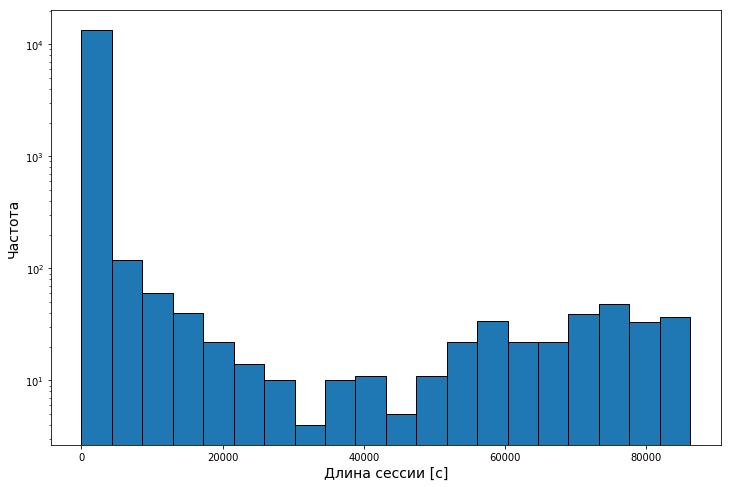

In [16]:
pylab.figure(figsize(12,8))
pylab.xlabel('Длина сессии [с]', size=14)
pylab.ylabel('Частота', size=14)
train_data_10users['session_timespan'].hist(bins=20, edgecolor='black', grid=False, log=True);

Сессии, длина которых более 20000, может быть причиной того, что пользователь закончил посещение сайтов до следующего дня, так что подобные записи будут чуть менее информативные.

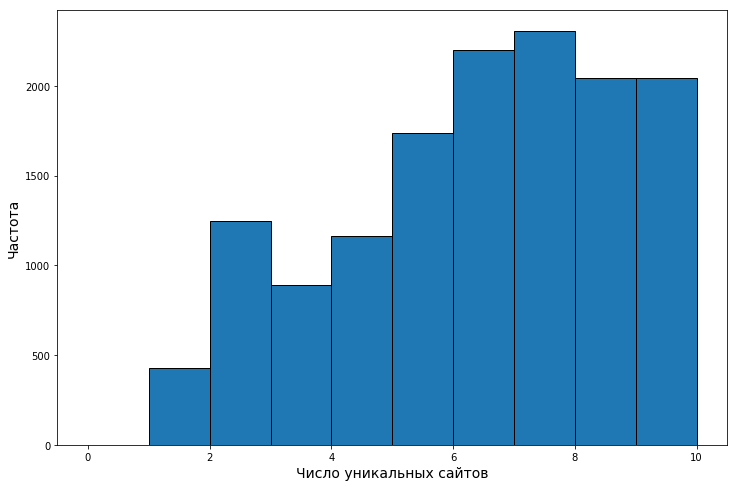

In [17]:
pylab.figure(figsize(12,8))
pylab.xlabel('Число уникальных сайтов', size=14)
pylab.ylabel('Частота', size=14)
train_data_10users['#unique_sites'].hist(bins=np.arange(11), edgecolor='black', grid=False);

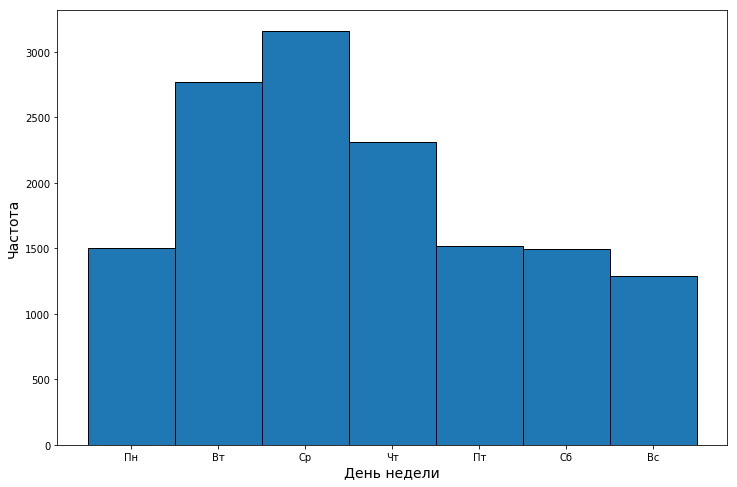

In [18]:
x_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pylab.xlabel('День недели', size=14)
pylab.ylabel('Частота', size=14)
pylab.xticks(np.arange(7), x_labels)
train_data_10users['day_of_week'].hist(bins=np.arange(8), align='left', edgecolor='black', grid=False);

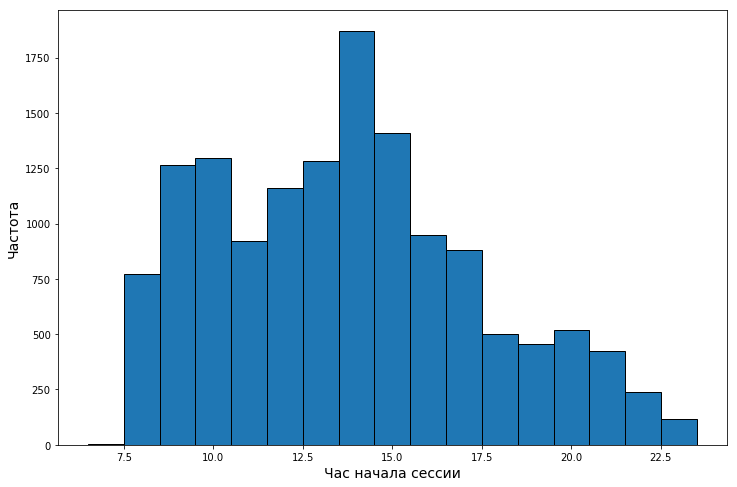

In [19]:
pylab.xlabel('Час начала сессии', size=14)
pylab.ylabel('Частота', size=14)
train_data_10users['start_hour'].hist(bins=np.arange(7, 25), align='left', edgecolor='black', grid=False);

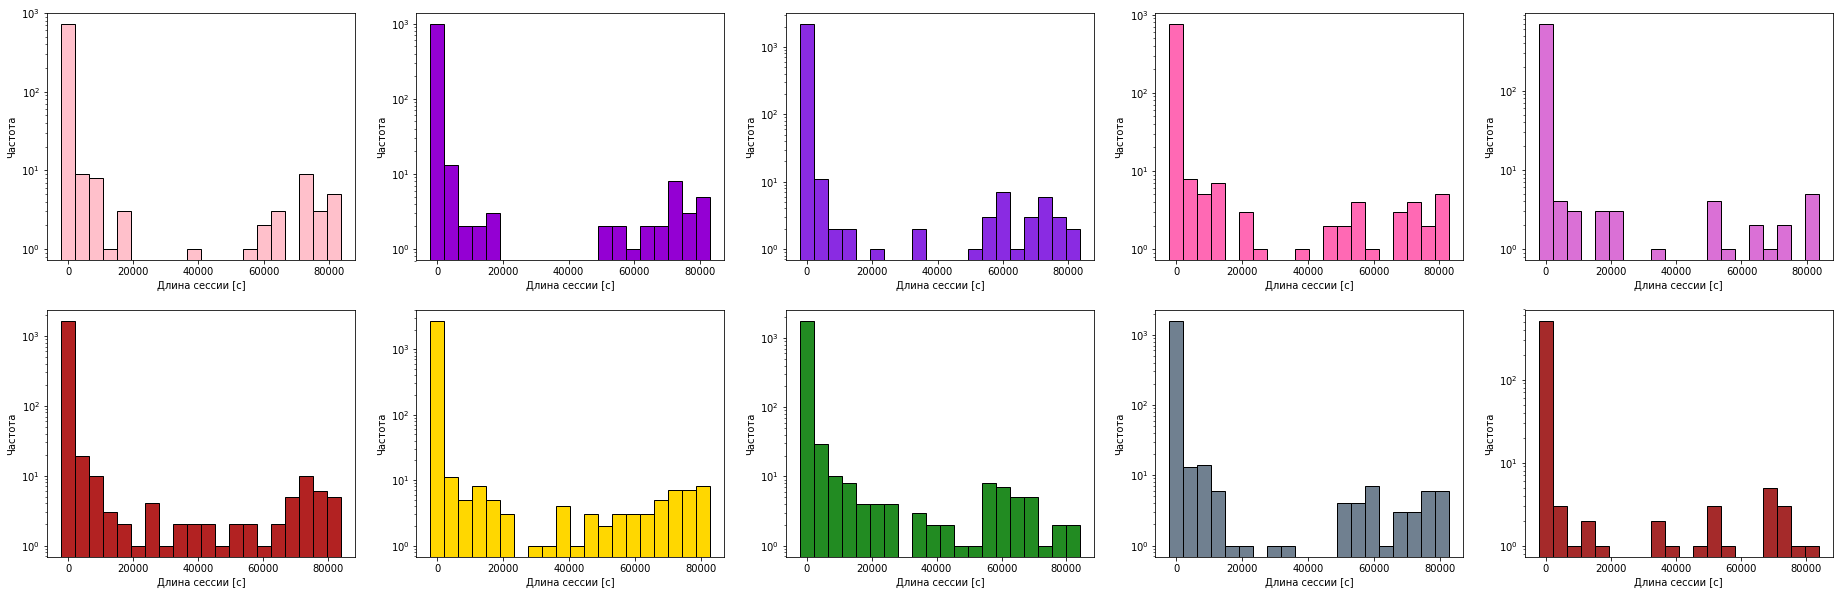

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 10))
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')):
    axes[int(idx/5), idx%5].hist(sub_df['session_timespan'].values, color=color_dic[user], 
                                 bins=20, edgecolor='black', align='left', log=True)
    
for ax in axes.flat:
    ax.set(xlabel='Длина сессии [с]', ylabel='Частота')

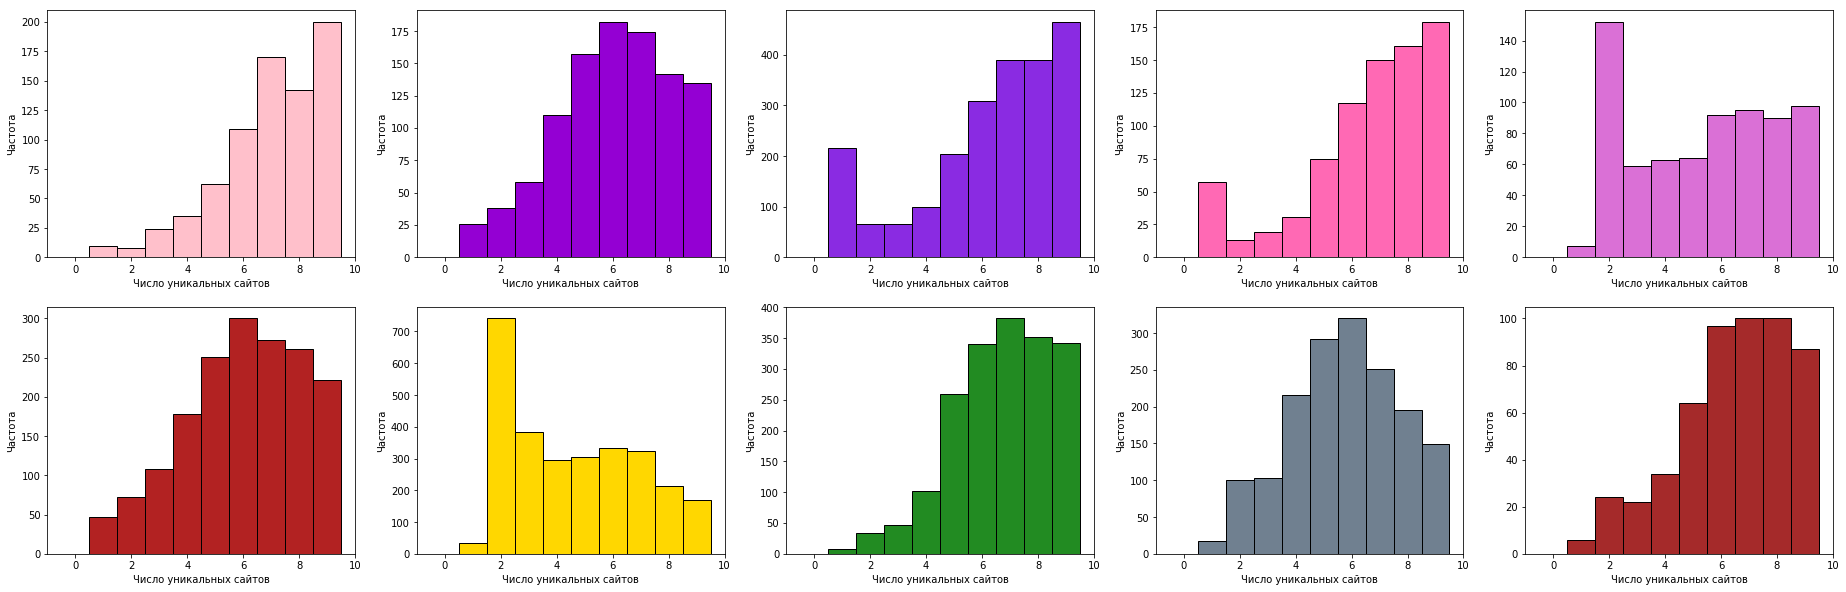

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 10))
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')):
    axes[int(idx/5), idx%5].hist(sub_df['#unique_sites'].values, color=color_dic[user], 
                                 bins=np.arange(11), edgecolor='black', align='left')
    
for ax in axes.flat:
    ax.set(xlabel='Число уникальных сайтов', ylabel='Частота')

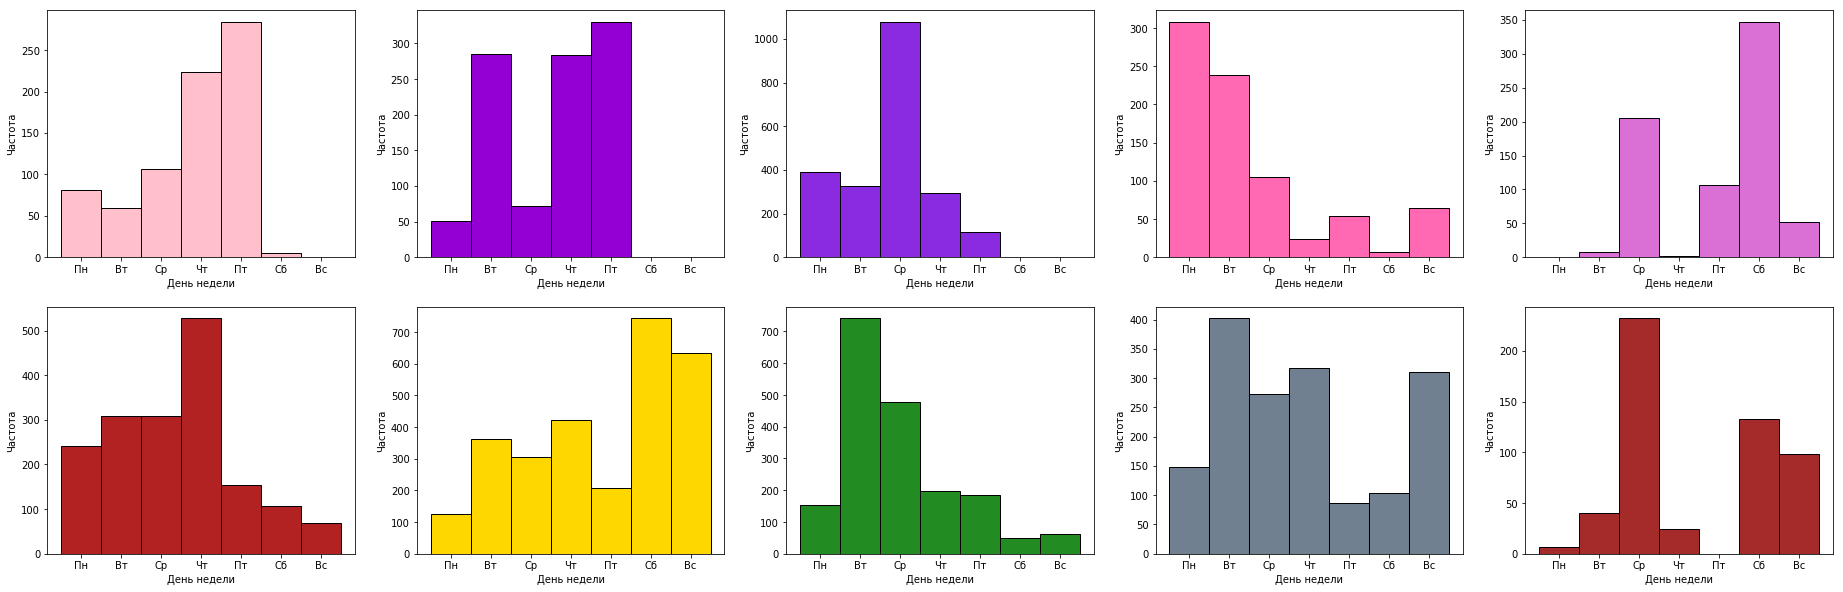

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 10))
x_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')):
    axes[int(idx/5), idx%5].hist(sub_df['day_of_week'].values, color=color_dic[user], 
                                 bins=np.arange(8), 
                                 align='left', edgecolor='black')
    axes[int(idx/5), idx%5].set_xticks(np.arange(7))
    axes[int(idx/5), idx%5].set_xticklabels(x_labels)
    
for ax in axes.flat:
    ax.set(xlabel='День недели', ylabel='Частота')

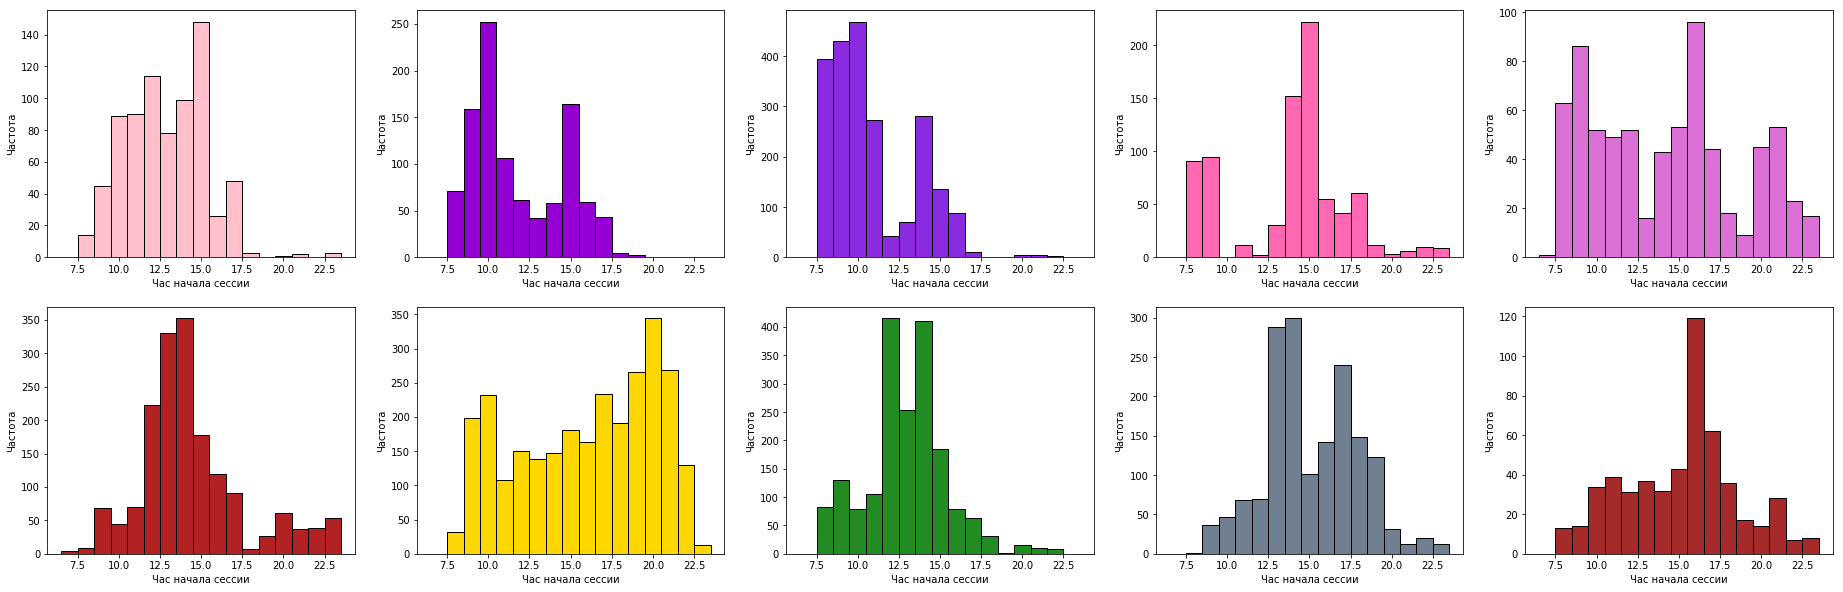

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 10))
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')):
    axes[int(idx/5), idx%5].hist(sub_df['start_hour'].values, color=color_dic[user], 
                                 bins=np.arange(7, 25), edgecolor='black', align='left')
    
for ax in axes.flat:
    ax.set(xlabel='Час начала сессии', ylabel='Частота')

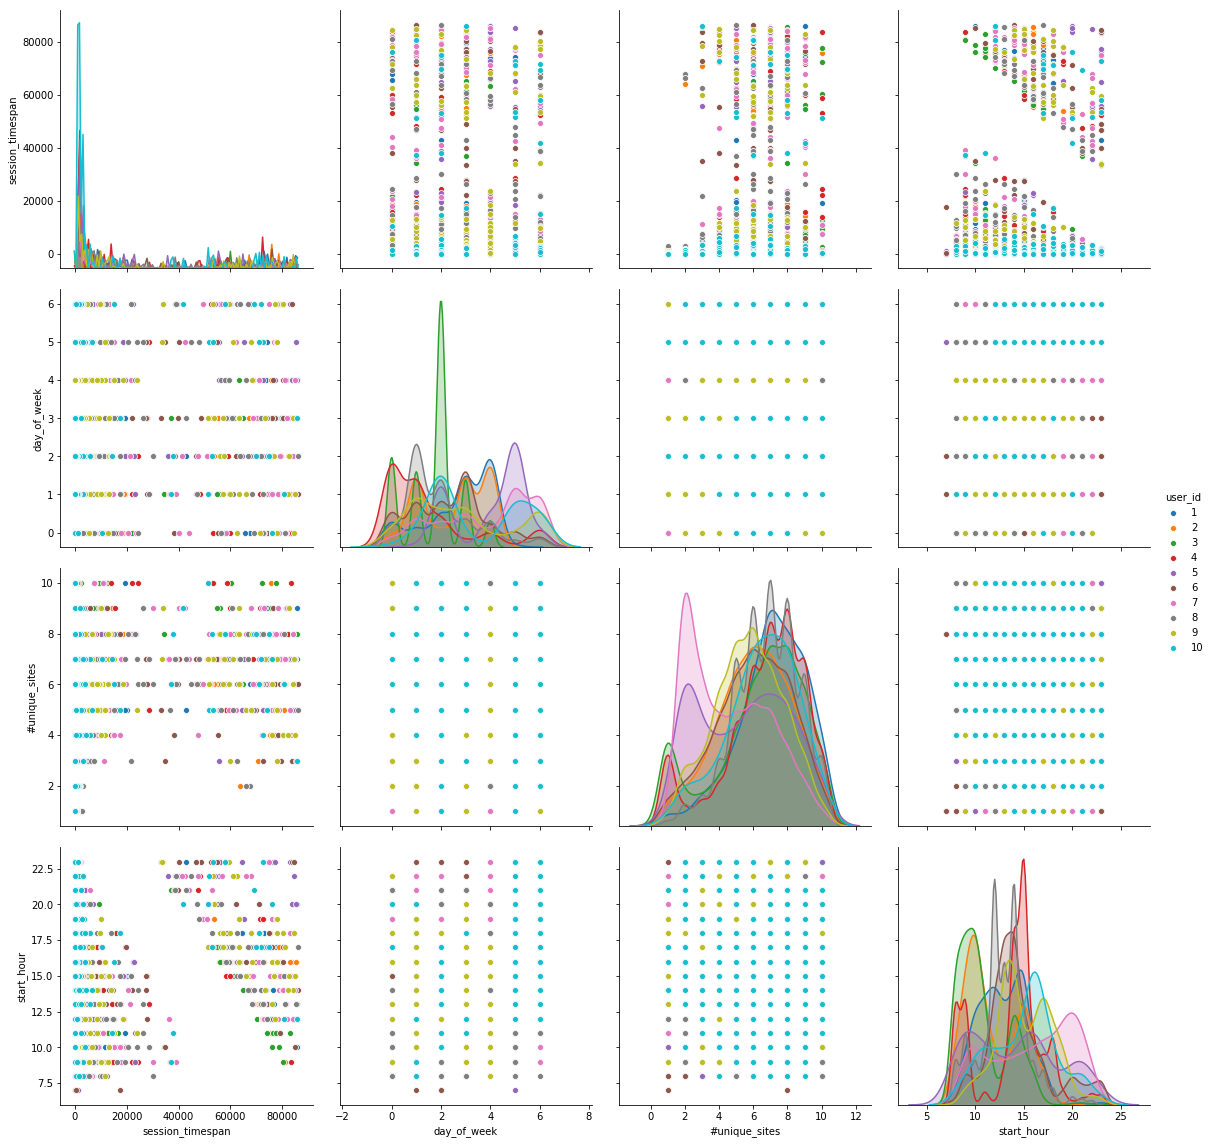

In [24]:
sns.pairplot(train_data_10users, hue="user_id", 
             vars=['session_timespan', 'day_of_week', '#unique_sites', 'start_hour'],
             height=4);

При сравнении графиков стоит отметить, что все пользователи имеют уникальную картину на графиках (особенно это заметно на последнем графике), что может давать повод использовать признаки для обучения.

P.S. Интересная картина на графике pairplot у параметров start_hour и session_timespan подтверждает теорию о том, что чаще всего большое значение длины сессии свидетельствует о том, что сессия состоит из части сессии, которая проходила перед сном, и из части сессии, которая проходила на следующий день.

## 5. Кросс-валидация, построение кривых валидации и обучения

Использовать будем только линейные модели из-за большого числа признаков. Заодно напишем дополнительные функции для построения кривых и обучения в целом.

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV

In [26]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=173)
estimator = SGDClassifier(random_state=173, loss='log')
estimator2 = LogisticRegressionCV(Cs=[2.642105263157895], random_state=173)

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Количество примеров")
    plt.ylabel("Оценка")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Тренировочная оценка")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Кросс-валидационная оценка")

    plt.legend(loc="best")
    return plt

In [28]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=173, test_size=0.3):    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    title = "Кривые обучения и валидации"
    plot_learning_curve(estimator, title, X_sparse, y, cv=cv, n_jobs=-1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    answer1 = cross_val_score(estimator, X_train, y_train, cv=cv)
    estimator.fit(X_train, y_train)
    answer2 = accuracy_score(y_valid, estimator.predict(X_valid))
    print(np.mean(answer1), answer2)

In [29]:
import warnings
warnings.filterwarnings('ignore')

Длина сессии: 7, длина окна: 7
0.435726299205893 0.4356334465932606


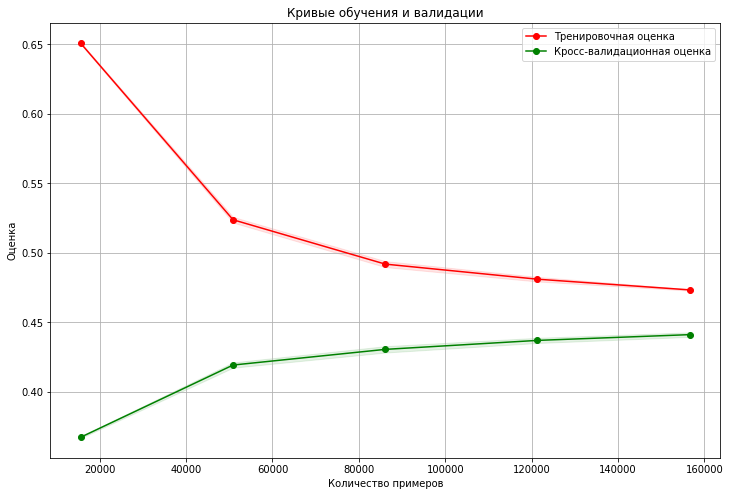

In [30]:
window_size, session_length = 7, 7
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Длина сессии: 10, длина окна: 7
0.49558238061782806 0.49952737398768615


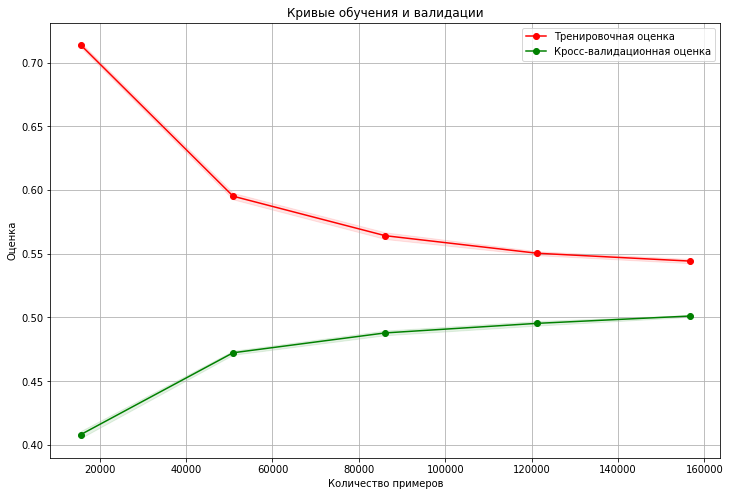

In [31]:
window_size, session_length = 7, 10
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Длина сессии: 10, длина окна: 10
0.4767443628457176 0.4763173259378193


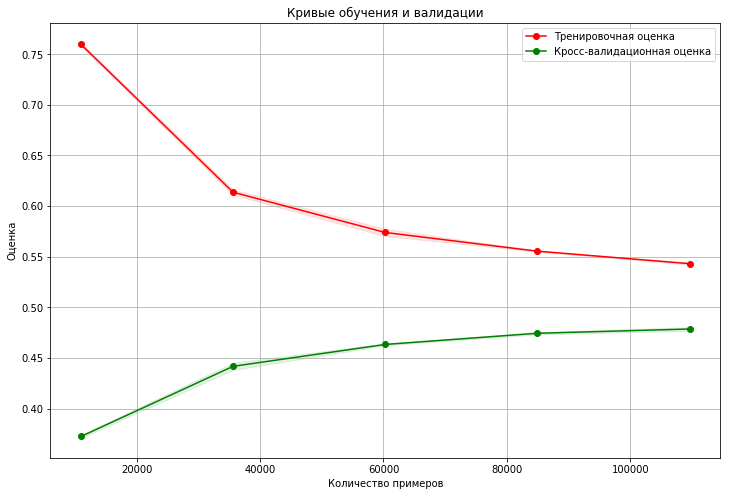

In [32]:
window_size, session_length = 10, 10
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Длина сессии: 15, длина окна: 5
0.5858371546551684 0.5887355818367644


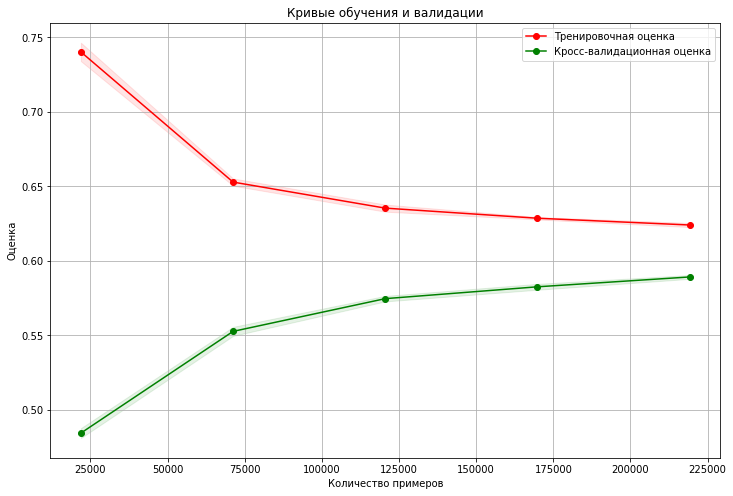

In [40]:
window_size, session_length = 5, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Длина сессии: 15, длина окна: 7
0.5703412744033552 0.5749942518457962


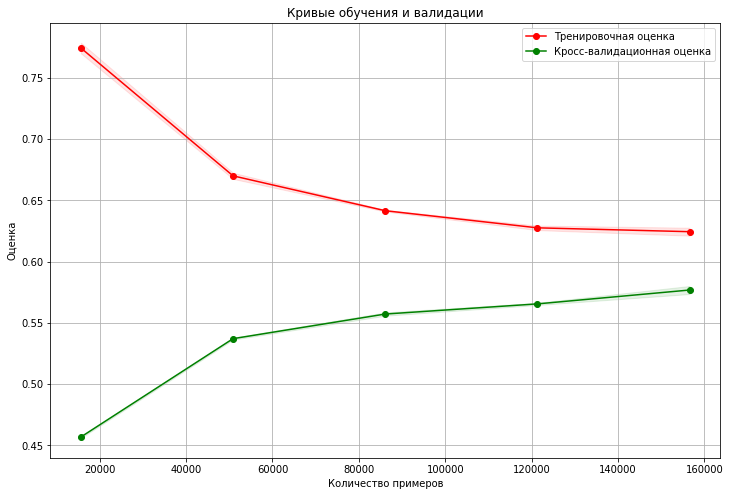

In [33]:
window_size, session_length = 7, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Длина сессии: 15, длина окна: 10
0.5511259103833114 0.5550649540213107


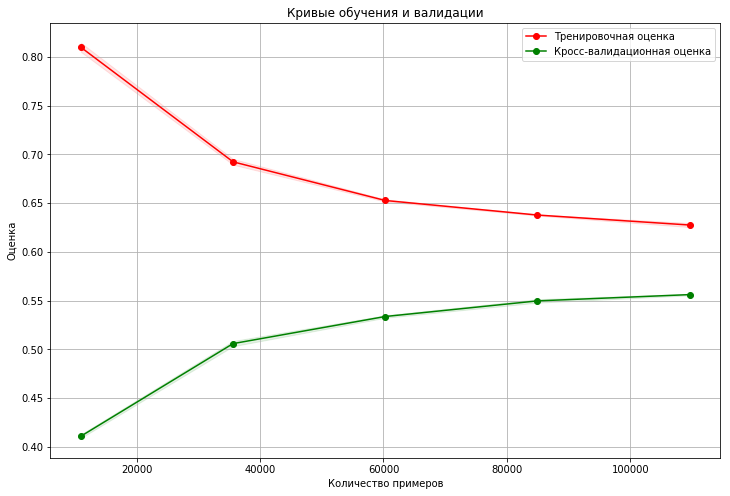

In [34]:
window_size, session_length = 10, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment(estimator, 
                 path_to_X_pkl, 
                 path_to_y_pkl, 
                 cv, 
                 random_state=173, 
                 test_size=0.2)

Заметно, что качество модели выше всего при разделении выборки на сессии длиной в 15 и шириной окна в 5 сайтов. Однако эта точность мала, и лучшим решением будет использовать подход one-vs-all, чтобы выделять одного пользователя среди остальных.

In [35]:
def model_assessment_one_vs_all(estimator, path_to_X_pickle, path_to_y_pickle, cv, user=6, random_state=173, test_size=0.3):    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    y[y != user] = 0
    y[y == user] = 1
    title = "Кривые обучения и валидации"
    plot_learning_curve(estimator, title, X_sparse, y, cv=cv, n_jobs=-1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    estimator.fit(X_train, y_train)
    answer2 = accuracy_score(y_valid, estimator.predict(X_valid))
    print(answer2)

SGDClassifier: Длина сессии: 15, длина окна: 5
0.9967696014016645


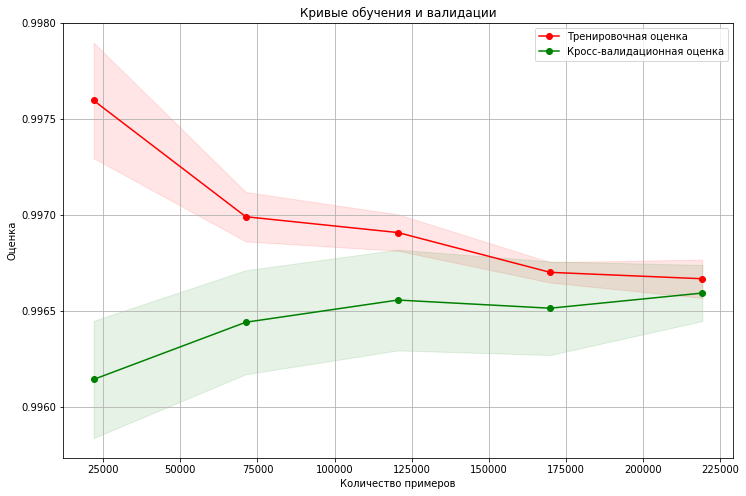

In [41]:
window_size, session_length = 5, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("SGDClassifier: Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment_one_vs_all(estimator, 
                            path_to_X_pkl, 
                            path_to_y_pkl, 
                            cv, 
                            random_state=173, 
                            test_size=0.2)

Сравним его с LogisticRegression:

LogisticRegression: Длина сессии: 15, длина окна: 5
0.9978646517739816


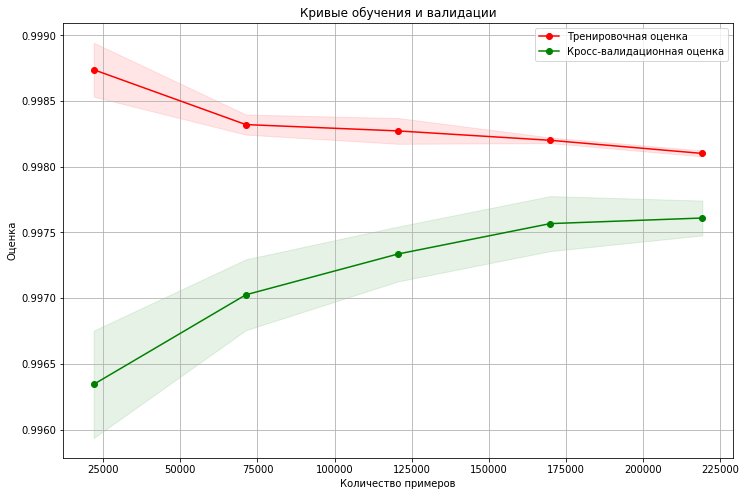

In [42]:
window_size, session_length = 5, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
print("LogisticRegression: Длина сессии: {}, длина окна: {}".format(session_length, 
                                                window_size))
model_assessment_one_vs_all(estimator2, 
                            path_to_X_pkl, 
                            path_to_y_pkl, 
                            cv, 
                            random_state=173, 
                            test_size=0.2)

Высокая точность достигается благодаря сильной несбалансированности выборки. Также мы не можем быть уверены, что у всех пользователей также хорошо, надо проверить. Перепишем функцию, поменяв заодно метрику на f1 для лучшей оценки качества. Заодно поменяем модель с SGDClassifier на LogisticRegression, так как он показал себя лучше на тесте.

In [38]:
def model_assessment_one_vs_all_f1_score(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=173, test_size=0.3):    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y_init = pickle.load(y_pkl)
    answers = []
    for user in np.unique(y_init):
        y = numpy.array(y_init)
        y[y != user] = 0
        y[y == user] = 1
        X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                         random_state=random_state, stratify=y)
        estimator.fit(X_train, y_train)
        answers.append(f1_score(y_valid, estimator.predict(X_valid)))
    return answers

In [43]:
window_size, session_length = 5, 15
path_to_X_pkl = path_X_sparse_150users.format(session_length, window_size)
path_to_y_pkl = path_y_sparse_150users.format(session_length, window_size)
f1_scores = model_assessment_one_vs_all_f1_score(estimator2, 
                                path_to_X_pkl, 
                                path_to_y_pkl, 
                                cv,
                                random_state=173, 
                                test_size=0.2)
print ("Средняя оценка f1: {}, среднее отклонение: {}".format(np.mean(f1_scores),np.std(f1_scores)))

Средняя оценка f1: 0.6320578532808718, среднее отклонение: 0.1538782221017925


## 6. Оценка модели с описанием выбранной метрики. 



Метрика f1_score, по мне, наиболее подходящая оценка в данной задаче. Она является взвешенной оценкой метрик precision и recall, которые зависят от трёх показателей:
- true positive (TP); 
- false positive (FP);
- false negative (FN). 

Это означает, что она не зависит от true negative (TN), которого в каждой задаче очень много (модель учится на одного пользователя против остальных).

Среднее значение 0.63 можно считать удовлетворительным, но не идеальным. В случае сбалансированной выборки двух классов случайный ответ получит оценку f1 0.5. Стоит отметить, что несбалансированность выборки получает совершенно другой уровень. Можно его примерно посчитать:

- Всего 150 пользователей, тогда в среднем каждый присутствует в 0.67% записей;
- Предположим, что случайный алгоритм в 50% случаев даёт положительный ответ;
- Сделаем допущение, что все TP попали в эти случайные ответы;
- Получается, что precision = 1, recall = 0.67%/50% = 0.0134
- Тогда $$f1 = 2 * \frac{precision * recall}{precision + recall} = 2 * \frac{1 * 0.0134}{1 + 0.0134} = 0.026$$

0.026 << 0.63, что даёт судить о хорошем качестве модели.

## 7. Выводы 

Полученную модель можно использовать в следующих ситуациях:
 - Выявление взлома аккаунта пользователя. Если обучить модель на одного пользователя по принципу one-vs-all, то можно выявлять подозрительные активности аккаунта и затем отправлять на почту уведомление о подозрительной активности аккаунта с предложением сменить пароль (или даже блокировать аккаунт, чтобы предотвратить использование почты третьими лицами);
 - Выявление нехарактерного поведения пользователя в сети. Есть шанс, что пользователь переживает серьезные проблемы, и скорое выявление проблем может помочь предотвратить ужасные последствия.

Возможные развития модели:
- Самым лучшим направлением, на мой взгляд, будет сборка сессий в определенный порог времени (к примеру, полчаса). Конечно, с помощью скользящего окна мы устранили эффект длительных пауз, но строки с огромной длиной сессии (до 80000 секунд) еще существует;
- Можно объединять сайты одного домена, чтобы уменьшать число признаков и улучшать связность между сайтами;
- Всё ещё можно добавлять признаки, однако категоризация новых признаков будет, скорее всего, необходима.

В итоге можно сказать, что задача идентификации пользователей - не самая простая, требует тщательной предобработки данных и аккуратного введения новых признаков.